# **本章重点（上篇）**

1. 封装自定义策略类
2. 策略订单的类型介绍
3. 策略订单的类型详细解释
4. 订单的有效期设置
5. 订单在策略中使用方式的举例

## **导入依赖包**

In [1]:
import backtrader as bt
import tushare as ts
import pandas as pd
import akshare as ak
import numpy as np
from backtrader.feeds import PandasData
from datetime import datetime as dt
import warnings
import os
from datetime import datetime, timedelta # 增加了时间模块
import quantstats as qs
import talib as ta
import backtrader.indicators as btind
warnings.filterwarnings("ignore")

## **扩充上一节中的回测函数——加入缓存**

有时候发现akshare会报错，无法获取行情数据，因此加入缓存功能

In [2]:
def backtest(strategy, stock_code, index_code,
             start_date,end_date, start_cash=1000000,
             report_mode='basic', price_type=None, use_cache=True):
    
    cerebro = bt.Cerebro()
    
    local_cache_file_name = f'{stock_code}_{start_date}_{end_date}_{price_type}' if price_type else f'{stock_code}_{start_date}_{end_date}_bfq'
    local_cache_file_name += '.csv'
    
    if use_cache and os.path.exists(local_cache_file_name):
        print('Using cache: ', local_cache_file_name)
        stock_data =  pd.read_csv(local_cache_file_name)
        stock_data.date=pd.to_datetime(stock_data.date)
        stock_data.sort_values(by='date', inplace=True)
    else:
        if price_type:
            stock_data = ak.stock_zh_a_hist(symbol=stock_code, period="daily", start_date=start_date, end_date=end_date, adjust=price_type)
        else:
            stock_data = ak.stock_zh_a_hist(symbol=stock_code, period="daily", start_date=start_date, end_date=end_date)
        stock_data.rename(columns={'日期':'date','开盘':'open','收盘':'close','最高':'high','最低':'low','成交量':'volume','换手率':'turnover'},inplace=True)
        stock_data = stock_data[['date', 'open', 'high', 'low', 'close', 'volume']]
        stock_data.date=pd.to_datetime(stock_data.date)
        stock_data.to_csv(local_cache_file_name, index=False)
        
    stock_data = PandasData(
                dataname=stock_data,
                datetime=0, 
                open=1, 
                high=2,
                low=3,
                close=4,
                volume=5,
                fromdate=dt.strptime(start_date, '%Y%m%d'),  # 起始日  dt.strptime(start, '%Y%m%d')
                todate=dt.strptime(end_date, '%Y%m%d'),  # 结束日
            )
    
    index_code = f'sz{index_code}' if str(index_code).startswith('3') else f'sh{index_code}'
    
    index_file = f'{index_code}.csv'
    if use_cache and os.path.exists(index_file):
        stock_zh_index_daily_df = pd.read_csv(index_file)
    else:
        stock_zh_index_daily_df = ak.stock_zh_index_daily(symbol=index_code)
        stock_zh_index_daily_df.to_csv(index_file, index=False)

    stock_zh_index_daily_df.date = pd.to_datetime(stock_zh_index_daily_df.date)
    
    cerebro.adddata(stock_data, name='stock')

    

    cerebro.addstrategy(strategy)
    # 设置现金
    cerebro.broker.setcash(start_cash)
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
    cerebro.broker.set_checksubmit(False)
    print('初始市值: %.2f' % cerebro.broker.getvalue())
    results = cerebro.run()
    strat = results[0]

    portfolio_stats = strat.analyzers.getbyname('PyFolio')
    returns, _,_,_ = portfolio_stats.get_pf_items()

    returns.index=returns.index.tz_convert(None)
    print('最终市值: %.2f' % cerebro.broker.getvalue())
    
    """
    qs.reports.metrics(mode='basic|full", ...) - shows basic/full metrics
    qs.reports.plots(mode='basic|full", ...) - shows basic/full plots
    qs.reports.basic(...) - shows basic metrics and plots
    qs.reports.full(...) - shows full metrics and plots
    qs.reports.html(...) - generates a complete report as html
    """
    
    bm = stock_zh_index_daily_df[['date','close']]
    bm.set_index('date', inplace=True)
    bm.rename(columns={'close':'price'}, inplace=True)
    bm = bm.loc[start_date:end_date]
    if report_mode == 'basic':
        qs.reports.basic(returns, benchmark=bm)
    elif report_mode == 'full':
        qs.reports.full(returns, benchmark=bm)
    elif report_mode == 'simple':
        qs.plots.snapshot(returns, title='Performance')

## **1.封装自定义策略基类StrategyBase**

把一些常用的方法封装在一个基类中

In [3]:
class StrategyBase(bt.Strategy):
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def get_current_dt(self):
        return self.datas[0].datetime.date(0)

    # 打印订单日志
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # 订单状态 submitted/accepted，无动作
            return

        # 订单完成
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('买单执行%s, 成交价：%.2f, 共%i股, 共花费%.2f资金' % (order.data._name,
                                                order.executed.price, order.executed.size, order.executed.price * order.executed.size))

            elif order.issell():
                self.log('卖单执行%s, 成交价：%.2f, 共%i股, 共花费%.2f资金' % (order.data._name,
                                                order.executed.price, -1 * order.executed.size,  -1 * order.executed.price * order.executed.size))

        else:
            self.log('订单作废 %s, %s, isbuy=%i' %
                     (order.data._name, order.getstatusname(), order.isbuy()))

    def notify_trade(self, trade):
        if trade.isclosed:
            date = trade.data.datetime.date(0).strftime('%Y%m%d')
            name = trade.data._name
            pnl = trade.pnl
            
            self.log('日期：%s, 交易完毕, %s, 毛收益 %0.2f, 扣佣后收益 % 0.2f, 佣金 %.2f, 市值 %.2f' %
                  (trade.data.datetime.date(0).strftime('%Y%m%d'), trade.data._name, trade.pnl, trade.pnlcomm, trade.commission, self.broker.getvalue()))

## **2.策略订单的类型介绍——订单管理与执行**

### **2.1 买卖下单的函数签名**
```
以买单举例：
buy(self, 
    owner, data,
    size, price=None, plimit=None,
    exectype=None, valid=None, 
    
    tradeid=0, oco=None,
    trailamount=None, trailpercent=None,
    parent=None, transmit=True,
    histnotify=False, _checksubmit=True,
    **kwargs)
```

###  **2.2 Order（订单）执行类型**

exectype是关键，有下面这些参数可以选择

1. Market
2. Close
3. Limit
4. Stop
5. StopLimit
6. StopTrail
7. StopTrailLimit

### **2.2 OrderData**

> **这个类在Order中使用，用于记录订单创建和成交时的数据，可以用于对比创建和实际成交的差别，主要包含以下关键属性：**

```
exbits ：记录一组OrderExecutionBits（或者说迭代器），用于记录所有成交（包括部分成交）的信息。
dt：创建/成交的时间
size：请求和成交的规模，就是这一单的下注金额。
price：成交的价格 注意： 如果没有设定price和pricelimite参数, 当前的收盘价或者订单创建时的收盘价会作为参考。
pricelimit：为 StopLimit类型的订单保存保存 pricelimit价格。
trailamount：追踪止损单的价格绝对差值。
trailpercent：追踪止损单的价格百分比差值。
value：当前订单头寸下的市值。
comm：订单本次成交的佣金。
pnl：全称profit and loss，订单的利润/损失，只有订单平仓，一次交易完成才有pnl。
margin：订单导致的保证金，这个在支持保证金（融资）交易的券商有作用。
psize：当前开仓的规模。
pprice：当前开仓的价格。
```

## **3.策略订单类型的详细解释**

### **3.1 Market 市价单(默认订单类型)**

下一个交易日的开盘价成交

**用法：**self.buy(size=100) 或者 self.buy(size=100, exectype=bt.Order.Market)

### **3.2 Close 收盘价订单**

下一个交易日的收盘价成交

**用法：**self.buy(size=100, exectype=bt.Order.Close)

### **3.3 Limit 限价单**

**用法：**self.buy(size=100, exectype=bt.Order.Limit, price=self.data.close * 1.05)

### **3.4 Stop 停止单**

这个停止单的叫法比较含糊，很容易让人误解，这个订单是与“突破”有关的

**用法**：self.buy(size=100, exectype=bt.Order.Stop, price=self.data.close * 1.05)

![盘口](images/订单.png)

### **3.5 StopLimit 停止限价单**

**在Stop的基础上，增加了限价功能**

```
以买单为例
price = self.data.open[1] + 0.01
self.buy(size=size, exectype=bt.Order.StopLimit, 
         price=price, plimit=price-0.02)
```
![盘口](images/订单02.png)

### **3.6 StopTrail 动态停止单**

**用法：可以用来做为止损，且是动态止损**
```
self.sell(size=1, exectype=bt.Order.StopTrail, trailamount=0.25)
或者
self.sell(size=1, exectype=bt.Order.StopTrail,price=15, trailpercent=0.02)
```
**说明：**
1. 订单类型要使用 exectype=bt.Order.StopTrail

2. 动态停止单有两种细分的价格设定方法：

    固定停止单: trailamount=10

    百分比停止单: trailpercent=0.02 (i.e.: 2%)


**举例来说，如果目前已有一笔多头（已经买了股票了），这个时候如果创建一个StopTrail类型的卖单，会有以下几种情况：**
1. 如果不设置价格，那么会默认使用收盘价Close作为基准价格
2. 触发的（止损）价格stop=设置的基准价格 - trailamount(绝对量)
3. 在下个交易日，broker会检查是否触发价已经被击中了：

    如果被击中：那么订单会以市价单成交
    
    如果未被击中：那么stop价格会用最新的基准价格（默认为close）可能会被重新计算，这又有两种情况：
    

    a. 如果价格上涨, 那么stop就会被重新计算
    
    b. 如果价格没有上涨或者持平，那么stop不会重新计算

**如果已经有了一笔空头持仓，那么这个时候用买单是同样的道理**

### **3.7 StopTrailLimit动态停止限价单**

**用法：可以用来做为止损，且是动态止损**
```
self.sell(size=1, exectype=bt.Order.StopTrailLimit, trailamount=2, plimit=10)
或者
self.sell(size=1, exectype=bt.Order.StopTrailLimit, price=15, trailpercent=0.02, plimit=10)
```
这里的情况类似于上面的stopLimit，不过多解释

## **4.订单的有效期设置**

**说明：过期的订单会自动失效**

**用法：**
```
valid = self.data.datetime.date(0) + timedelta(days=1)
self.buy(size=size, exectype=bt.Order.Limit, price=price, plimit=price-0.02,  valid=valid)
```

## **5.订单在策略中使用方式的举例**

#### **注意：本次我们只使用95%的资金进行买卖，保留5%来cover手续费**

size = int(self.broker.getvalue()*0.95 / self.datas[0].open[1] // 100 * 100)  # 股数

### **5.1 限价单Limit**

#### **情况一：**Limit > open[1]

In [4]:
class Strategy01(StrategyBase):
    params = {
        'period01':5, 'period02': 5
    }
    
    def __init__(self):
        # 先在 __init__ 中提前算好指标，单只股票的情况下，直接用self.data就是默认指向了第一支股票的close价格（也是唯一一支）
        sma1 = btind.SMA(self.data, period=self.p.period01)
        ema1 = btind.ExponentialMovingAverage( period=self.p.period02)
        self.sma1 = sma1
        self.ema1 = ema1
        # 下面的都是序列
        
        self.stop_price = 13  # 设置止损价
        
        self.buy_signal = bt.And(self.data.close> sma1, self.data.close> ema1)
        self.sell_signal = bt.And(self.data.close< sma1, self.data.close< ema1)
        self.count = 0
    
    
    def next(self):
        self.count += 1
        today = self.data.datetime.date(0)
        
        valid = self.data.datetime.date(0) + timedelta(days=1)
        if len(self.data) >= self.data.buflen():
            return
        print(f'============================= {today} ===========================')
            
        size = int(self.broker.getvalue()*0.95 / self.datas[0].open[1] // 100 * 100)  # 股数
        
        
        if not self.position.size:  # 还没有仓位的情况下，观察入场信号
            if self.buy_signal:
                print(f'第二天open为    {self.data.open[1]}')
                print(f'第二天high为    {self.data.high[1]}')
                print(f'第二天low为     {self.data.low[1]}')
                print(f'第二天close为   {self.data.close[1]}')
                
                limit_price = self.data.open[1] + 0.2  # 或者也可以用self.data.close * 0.95 之类的方式
                print(f'准备买入{size}股，limit价格：{limit_price}，需要花费金额：{size * self.data.open[1]}')
                self.buy(size=size, exectype=bt.Order.Limit, price=limit_price, valid=valid)
                
        else:  # 有仓位的情况下，观察立场信号
            if self.sell_signal:
#                 print(f'>>> 准备卖出')
#                 print(f'第二天open为    {self.data.open[1]}')
#                 print(f'第二天high为    {self.data.high[1]}')
#                 print(f'第二天low为     {self.data.low[1]}')
#                 print(f'第二天close为   {self.data.close[1]}')
#                 price = self.data.open[1] -0.2
#                 print(f'准备买入{size}股，停损价：{price}，需要花费金额：{size * self.data.open[1]}')
                
#                 self.sell(size=self.position.size, exectype=bt.Order.Stop, price=price)

                self.close()
        

初始市值: 1000000.00
============================= 2019-01-08 ===========================
第二天open为    9.74
第二天high为    10.08
第二天low为     9.7
第二天close为   9.94
准备买入97500股，limit价格：9.94，需要花费金额：949650.0
2019-01-09, 买单执行stock, 成交价：9.74, 共97500股, 共花费949650.00资金
============================= 2019-01-09 ===========================
============================= 2019-01-10 ===========================
============================= 2019-01-11 ===========================
============================= 2019-01-14 ===========================
============================= 2019-01-15 ===========================
============================= 2019-01-16 ===========================
============================= 2019-01-17 ===========================
============================= 2019-01-18 ===========================
============================= 2019-01-21 ===========================
============================= 2019-01-22 ===========================
2019-01-23, 卖单执行stock, 成交价：10.29, 共97500股, 共花费1003275.00资金


                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2019-01-09   2019-01-09
End Period          2019-12-31   2019-12-31
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       66.0%

Cumulative Return   23.15%       32.29%
CAGR﹪              15.88%       21.91%

Sharpe              1.06         1.43
Prob. Sharpe Ratio  84.51%       93.15%
Sortino             1.56         2.6
Sortino/√2          1.1          1.84
Omega               1.37         1.37

Max Drawdown        -21.65%      -11.36%
Longest DD Days     268          156

Gain/Pain Ratio     0.2          0.37
Gain/Pain (1M)      1.52         2.72

Payoff Ratio        1.25         1.49
Profit Factor       1.2          1.37
Common Sense Ratio  1.43         1.81
CPC Index           0.8          0.98
Tail Ratio          1.19         1.32
Outlier Win Ratio   4.02         6.17
Outlier Loss Ratio  3.37         3.43

MTD                 7.61%        2.29%
3M            

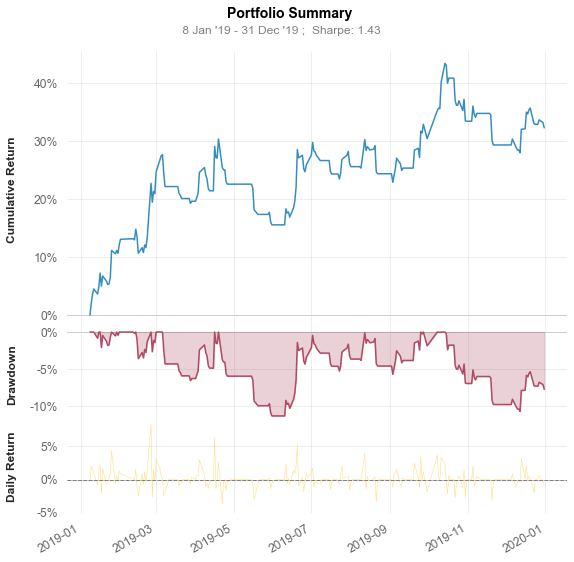

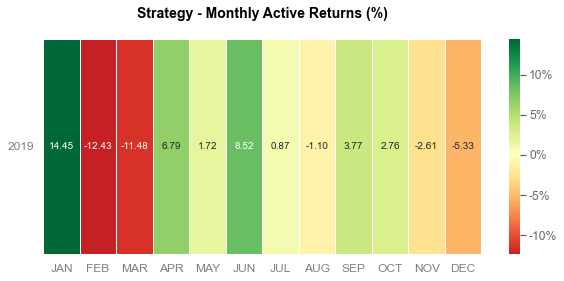

In [5]:
strategy = Strategy01
start_date = '20190101'
end_date   = '20200101'
stock_code = '000001'
index_code = '000905'

backtest(strategy, stock_code, index_code,
         start_date,end_date, 
         start_cash=1000000, report_mode='basic', price_type=None)

#### **情况二：** low < Limit < open[1]


In [6]:
class Strategy02(StrategyBase):
    params = {
        'period01':5, 'period02': 5
    }
    
    def __init__(self):
        # 先在 __init__ 中提前算好指标，单只股票的情况下，直接用self.data就是默认指向了第一支股票的close价格（也是唯一一支）
        sma1 = btind.SMA(self.data, period=self.p.period01)
        ema1 = btind.ExponentialMovingAverage( period=self.p.period02)
        self.sma1 = sma1
        self.ema1 = ema1
        # 下面的都是序列
        
        self.stop_price = 13  # 设置止损价
        
        self.buy_signal = bt.And(self.data.close> sma1, self.data.close> ema1)
        self.sell_signal = bt.And(self.data.close< sma1, self.data.close< ema1)
        self.count = 0
    
    
    def next(self):
        self.count += 1
        today = self.data.datetime.date(0)
        
        valid = self.data.datetime.date(0) + timedelta(days=1)
        if len(self.data) >= self.data.buflen():
            return
        print(f'============================= {today} ===========================')
            
        size = int(self.broker.getvalue()*0.95 / self.datas[0].open[1] // 100 * 100)  # 股数
        
        
        if not self.position.size:  # 还没有仓位的情况下，观察入场信号
            if self.buy_signal:
                print(f'第二天open为    {self.data.open[1]}')
                print(f'第二天high为    {self.data.high[1]}')
                print(f'第二天low为     {self.data.low[1]}')
                print(f'第二天close为   {self.data.close[1]}')
                
                limit_price = self.data.open[1] - 0.2  # 或者也可以用self.data.close * 0.95 之类的方式
                print(f'准备买入{size}股，limit价格：{limit_price}，需要花费金额：{size * self.data.open[1]}')
                self.buy(size=size, exectype=bt.Order.Limit, price=limit_price, valid=valid)
                
        else:  # 有仓位的情况下，观察立场信号
            if self.sell_signal:
#                 print(f'>>> 准备卖出')
#                 print(f'第二天open为    {self.data.open[1]}')
#                 print(f'第二天high为    {self.data.high[1]}')
#                 print(f'第二天low为     {self.data.low[1]}')
#                 print(f'第二天close为   {self.data.close[1]}')
#                 price = self.data.open[1] -0.2
#                 print(f'准备买入{size}股，停损价：{price}，需要花费金额：{size * self.data.open[1]}')
                
#                 self.sell(size=self.position.size, exectype=bt.Order.Stop, price=price)

                self.close()
        

Using cache:  000001_20190101_20200101_bfq.csv
初始市值: 1000000.00
============================= 2019-01-08 ===========================
第二天open为    9.74
第二天high为    10.08
第二天low为     9.7
第二天close为   9.94
准备买入97500股，limit价格：9.540000000000001，需要花费金额：949650.0
============================= 2019-01-09 ===========================
第二天open为    9.87
第二天high为    10.2
第二天low为     9.86
第二天close为   10.1
准备买入96200股，limit价格：9.67，需要花费金额：949493.9999999999
2019-01-10, 订单作废 stock, Expired, isbuy=1
============================= 2019-01-10 ===========================
第二天open为    10.11
第二天high为    10.22
第二天low为     10.05
第二天close为   10.2
准备买入93900股，limit价格：9.91，需要花费金额：949329.0
2019-01-11, 订单作废 stock, Expired, isbuy=1
============================= 2019-01-11 ===========================
第二天open为    10.22
第二天high为    10.25
第二天low为     10.07
第二天close为   10.11
准备买入92900股，limit价格：10.020000000000001，需要花费金额：949438.0000000001
2019-01-14, 订单作废 stock, Expired, isbuy=1
2019-01-14, 订单作废 stock, Expired, isbuy=1
============

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2019-01-17   2019-01-17
End Period          2019-12-31   2019-12-31
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       38.0%

Cumulative Return   21.46%       18.01%
CAGR﹪              15.12%       12.74%

Sharpe              1.01         1.16
Prob. Sharpe Ratio  83.1%        88.86%
Sortino             1.48         2.2
Sortino/√2          1.05         1.56
Omega               1.43         1.43

Max Drawdown        -21.65%      -7.12%
Longest DD Days     268          208

Gain/Pain Ratio     0.19         0.43
Gain/Pain (1M)      1.31         2.48

Payoff Ratio        1.19         1.51
Profit Factor       1.19         1.43
Common Sense Ratio  1.43         1.83
CPC Index           0.76         1.05
Tail Ratio          1.2          1.28
Outlier Win Ratio   3.39         11.71
Outlier Loss Ratio  3.04         3.43

MTD                 7.61%        0.46%
3M            

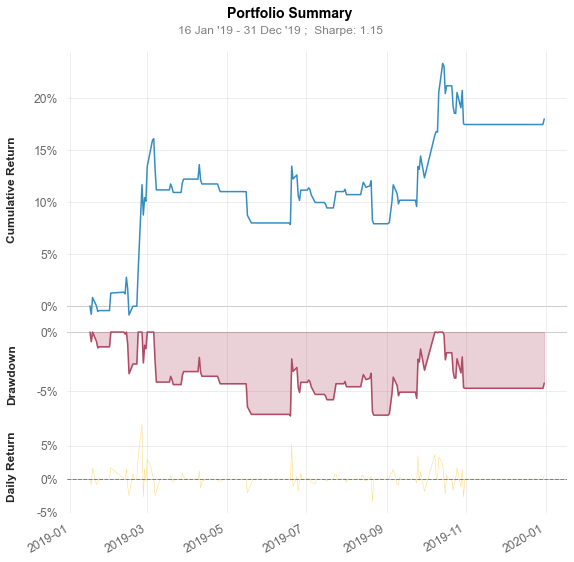

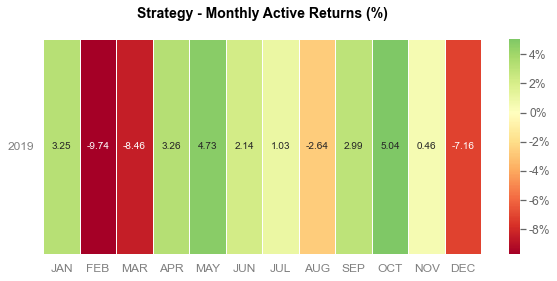

In [7]:
strategy = Strategy02
start_date = '20190101'
end_date   = '20200101'
stock_code = '000001'
index_code = '000905'

backtest(strategy, stock_code, index_code,
         start_date,end_date, 
         start_cash=1000000, report_mode='basic', price_type=None)

# 查看 2019-01-31的买单成交

#### **情况三：**Limit < low

这种情况肯定无法成交

### **5.2 停止单 Stop**

#### **情况四：**high > Stop > open[1]

In [8]:
class Strategy04(StrategyBase):
    params = {
        'period01':5, 'period02': 5
    }
    
    def __init__(self):
        # 先在 __init__ 中提前算好指标，单只股票的情况下，直接用self.data就是默认指向了第一支股票的close价格（也是唯一一支）
        sma1 = btind.SMA(self.data, period=self.p.period01)
        ema1 = btind.ExponentialMovingAverage( period=self.p.period02)
        self.sma1 = sma1
        self.ema1 = ema1
        # 下面的都是序列
        
        self.stop_price = 13  # 设置止损价
        
        self.buy_signal = bt.And(self.data.close> sma1, self.data.close> ema1)
        self.sell_signal = bt.And(self.data.close< sma1, self.data.close< ema1)
        self.count = 0
    
    
    def next(self):
        self.count += 1
        today = self.data.datetime.date(0)
        
        valid = self.data.datetime.date(0) + timedelta(days=1)
        if len(self.data) >= self.data.buflen():
            return
        print(f'============================= {today} ===========================')
            
        size = int(self.broker.getvalue()*0.95 / self.datas[0].open[1] // 100 * 100)  # 股数
        
        
        if not self.position.size:  # 还没有仓位的情况下，观察入场信号
            if self.buy_signal:
                print(f'第二天open为    {self.data.open[1]}')
                print(f'第二天high为    {self.data.high[1]}')
                print(f'第二天low为     {self.data.low[1]}')
                print(f'第二天close为   {self.data.close[1]}')
                
                order_stop_price = self.data.open[1] + 0.05
                print(f'准备买入{size}股，停止价：{order_stop_price}，需要花费金额：{size * self.data.open[1]}')
                self.buy(size=size, exectype=bt.Order.Stop, price=order_stop_price, valid=valid)
                
        else:  # 有仓位的情况下，观察立场信号
            if self.sell_signal:
#                 print(f'>>> 准备卖出')
#                 print(f'第二天open为    {self.data.open[1]}')
#                 print(f'第二天high为    {self.data.high[1]}')
#                 print(f'第二天low为     {self.data.low[1]}')
#                 print(f'第二天close为   {self.data.close[1]}')
#                 price = self.data.open[1] -0.2
#                 print(f'准备买入{size}股，停损价：{price}，需要花费金额：{size * self.data.open[1]}')
                
#                 self.sell(size=self.position.size, exectype=bt.Order.Stop, price=price)

                self.close()
     

Using cache:  000001_20190101_20200101_bfq.csv
初始市值: 1000000.00
============================= 2019-01-08 ===========================
第二天open为    9.74
第二天high为    10.08
第二天low为     9.7
第二天close为   9.94
准备买入97500股，停止价：9.790000000000001，需要花费金额：949650.0
2019-01-09, 买单执行stock, 成交价：9.79, 共97500股, 共花费954525.00资金
============================= 2019-01-09 ===========================
============================= 2019-01-10 ===========================
============================= 2019-01-11 ===========================
============================= 2019-01-14 ===========================
============================= 2019-01-15 ===========================
============================= 2019-01-16 ===========================
============================= 2019-01-17 ===========================
============================= 2019-01-18 ===========================
============================= 2019-01-21 ===========================
============================= 2019-01-22 ===========================
201

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2019-01-09   2019-01-09
End Period          2019-12-31   2019-12-31
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       59.0%

Cumulative Return   23.15%       36.17%
CAGR﹪              15.88%       24.42%

Sharpe              1.06         1.64
Prob. Sharpe Ratio  84.51%       95.83%
Sortino             1.56         3.07
Sortino/√2          1.1          2.17
Omega               1.47         1.47

Max Drawdown        -21.65%      -12.35%
Longest DD Days     268          158

Gain/Pain Ratio     0.2          0.47
Gain/Pain (1M)      1.52         4.0

Payoff Ratio        1.15         1.41
Profit Factor       1.2          1.47
Common Sense Ratio  1.43         1.78
CPC Index           0.74         1.04
Tail Ratio          1.19         1.21
Outlier Win Ratio   4.02         7.18
Outlier Loss Ratio  3.24         3.33

MTD                 7.61%        0.22%
3M            

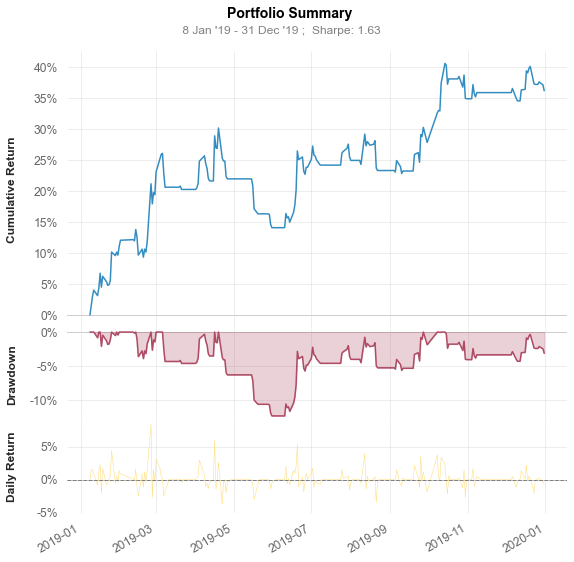

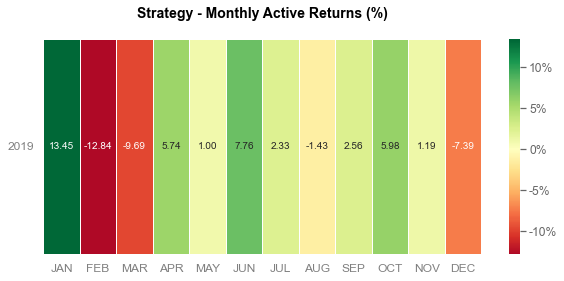

In [9]:
strategy = Strategy04
start_date = '20190101'
end_date   = '20200101'
stock_code = '000001'
index_code = '000905'

backtest(strategy, stock_code, index_code,
         start_date,end_date, 
         start_cash=1000000, report_mode='basic', price_type=None)

#### **情况五：** Stop > high

不会成交

In [10]:
class Strategy05(StrategyBase):
    params = {
        'period01':5, 'period02': 5
    }
    
    def __init__(self):
        # 先在 __init__ 中提前算好指标，单只股票的情况下，直接用self.data就是默认指向了第一支股票的close价格（也是唯一一支）
        sma1 = btind.SMA(self.data, period=self.p.period01)
        ema1 = btind.ExponentialMovingAverage( period=self.p.period02)
        self.sma1 = sma1
        self.ema1 = ema1
        # 下面的都是序列
        
        self.stop_price = 13  # 设置止损价
        
        self.buy_signal = bt.And(self.data.close> sma1, self.data.close> ema1)
        self.sell_signal = bt.And(self.data.close< sma1, self.data.close< ema1)
        self.count = 0
    
    
    def next(self):
        self.count += 1
        today = self.data.datetime.date(0)
        
        valid = self.data.datetime.date(0) + timedelta(days=1)
        if len(self.data) >= self.data.buflen():
            return
        print(f'============================= {today} ===========================')
            
        size = int(self.broker.getvalue()*0.95 / self.datas[0].open[1] // 100 * 100)  # 股数
        
        
        if not self.position.size:  # 还没有仓位的情况下，观察入场信号
            if self.buy_signal:
                print(f'第二天open为    {self.data.open[1]}')
                print(f'第二天high为    {self.data.high[1]}')
                print(f'第二天low为     {self.data.low[1]}')
                print(f'第二天close为   {self.data.close[1]}')
                
                order_stop_price = self.data.open[1] + 5
                print(f'准备买入{size}股，停损价：{order_stop_price}，需要花费金额：{size * self.data.open[1]}')
                self.buy(size=size, exectype=bt.Order.Stop, price=order_stop_price, valid=valid)
                
        else:  # 有仓位的情况下，观察立场信号
            if self.sell_signal:
#                 print(f'>>> 准备卖出')
#                 print(f'第二天open为    {self.data.open[1]}')
#                 print(f'第二天high为    {self.data.high[1]}')
#                 print(f'第二天low为     {self.data.low[1]}')
#                 print(f'第二天close为   {self.data.close[1]}')
#                 price = self.data.open[1] -0.2
#                 print(f'准备买入{size}股，停损价：{price}，需要花费金额：{size * self.data.open[1]}')
                
#                 self.sell(size=self.position.size, exectype=bt.Order.Stop, price=price)

                self.close()
     

Using cache:  000001_20190101_20200101_bfq.csv
初始市值: 1000000.00
============================= 2019-01-08 ===========================
第二天open为    9.74
第二天high为    10.08
第二天low为     9.7
第二天close为   9.94
准备买入97500股，停损价：14.74，需要花费金额：949650.0
============================= 2019-01-09 ===========================
第二天open为    9.87
第二天high为    10.2
第二天low为     9.86
第二天close为   10.1
准备买入96200股，停损价：14.87，需要花费金额：949493.9999999999
2019-01-10, 订单作废 stock, Expired, isbuy=1
============================= 2019-01-10 ===========================
第二天open为    10.11
第二天high为    10.22
第二天low为     10.05
第二天close为   10.2
准备买入93900股，停损价：15.11，需要花费金额：949329.0
2019-01-11, 订单作废 stock, Expired, isbuy=1
============================= 2019-01-11 ===========================
第二天open为    10.22
第二天high为    10.25
第二天low为     10.07
第二天close为   10.11
准备买入92900股，停损价：15.22，需要花费金额：949438.0000000001
2019-01-14, 订单作废 stock, Expired, isbuy=1
2019-01-14, 订单作废 stock, Expired, isbuy=1
============================= 2019-01-14 ==========

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2019-01-03   2019-01-03
End Period          2019-12-31   2019-12-31
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       0.0%

Cumulative Return   27.49%       0.0%
CAGR﹪              18.42%       0.0%

Sharpe              1.19         -
Prob. Sharpe Ratio  87.62%       -
Sortino             1.77         -
Sortino/√2          1.25         -
Omega               -            -

Max Drawdown        -21.65%      -
Longest DD Days     -            -

Gain/Pain Ratio     0.23         -
Gain/Pain (1M)      2.06         -

Payoff Ratio        -            -
Profit Factor       1.23         -
Common Sense Ratio  1.47         -
CPC Index           -            -
Tail Ratio          1.19         -
Outlier Win Ratio   1.71         -
Outlier Loss Ratio  1.83         -

MTD                 7.61%        0.0%
3M                  5.23%        0.0%
6M                  6.41%        

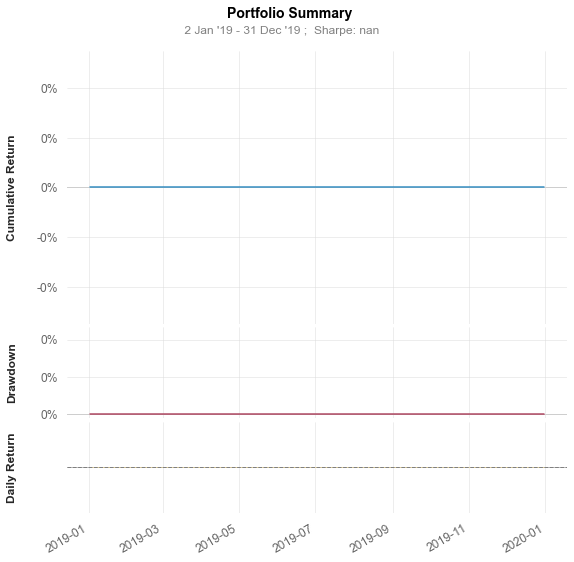

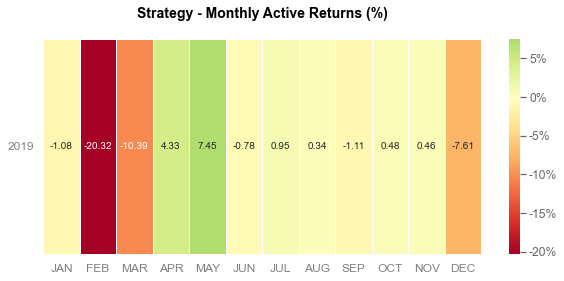

In [11]:
strategy = Strategy05
start_date = '20190101'
end_date   = '20200101'
stock_code = '000001'
index_code = '000905'

backtest(strategy, stock_code, index_code,
         start_date,end_date, 
         start_cash=1000000, report_mode='basic', price_type=None)

#### **情况六：**Stop < open[1]

In [12]:
class Strategy06(StrategyBase):
    params = {
        'period01':5, 'period02': 5
    }
    
    def __init__(self):
        # 先在 __init__ 中提前算好指标，单只股票的情况下，直接用self.data就是默认指向了第一支股票的close价格（也是唯一一支）
        sma1 = btind.SMA(self.data, period=self.p.period01)
        ema1 = btind.ExponentialMovingAverage( period=self.p.period02)
        self.sma1 = sma1
        self.ema1 = ema1
        # 下面的都是序列
        
        self.stop_price = 13  # 设置止损价
        
        self.buy_signal = bt.And(self.data.close> sma1, self.data.close> ema1)
        self.sell_signal = bt.And(self.data.close< sma1, self.data.close< ema1)
        self.count = 0
    
    
    def next(self):
        self.count += 1
        today = self.data.datetime.date(0)
        
        valid = self.data.datetime.date(0) + timedelta(days=1)
        if len(self.data) >= self.data.buflen():
            return
        print(f'============================= {today} ===========================')
            
        size = int(self.broker.getvalue()*0.95 / self.datas[0].open[1] // 100 * 100)  # 股数
        
        
        if not self.position.size:  # 还没有仓位的情况下，观察入场信号
            if self.buy_signal:
                print(f'第二天open为    {self.data.open[1]}')
                print(f'第二天high为    {self.data.high[1]}')
                print(f'第二天low为     {self.data.low[1]}')
                print(f'第二天close为   {self.data.close[1]}')
                
                order_stop_price = self.data.open[1] - 0.3
                print(f'准备买入{size}股，停损价：{order_stop_price}，需要花费金额：{size * self.data.open[1]}')
                self.buy(size=size, exectype=bt.Order.Stop, price=order_stop_price, valid=valid)
                
        else:  # 有仓位的情况下，观察立场信号
            if self.sell_signal:
#                 print(f'>>> 准备卖出')
#                 print(f'第二天open为    {self.data.open[1]}')
#                 print(f'第二天high为    {self.data.high[1]}')
#                 print(f'第二天low为     {self.data.low[1]}')
#                 print(f'第二天close为   {self.data.close[1]}')
#                 price = self.data.open[1] -0.2
#                 print(f'准备买入{size}股，停损价：{price}，需要花费金额：{size * self.data.open[1]}')
                
#                 self.sell(size=self.position.size, exectype=bt.Order.Stop, price=price)

                self.close()
     

Using cache:  000001_20190101_20200101_bfq.csv
初始市值: 1000000.00
============================= 2019-01-08 ===========================
第二天open为    9.74
第二天high为    10.08
第二天low为     9.7
第二天close为   9.94
准备买入97500股，停损价：9.44，需要花费金额：949650.0
2019-01-09, 买单执行stock, 成交价：9.74, 共97500股, 共花费949650.00资金
============================= 2019-01-09 ===========================
============================= 2019-01-10 ===========================
============================= 2019-01-11 ===========================
============================= 2019-01-14 ===========================
============================= 2019-01-15 ===========================
============================= 2019-01-16 ===========================
============================= 2019-01-17 ===========================
============================= 2019-01-18 ===========================
============================= 2019-01-21 ===========================
============================= 2019-01-22 ===========================
2019-01-23, 卖单执行

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2019-01-09   2019-01-09
End Period          2019-12-31   2019-12-31
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       66.0%

Cumulative Return   23.15%       32.29%
CAGR﹪              15.88%       21.91%

Sharpe              1.06         1.43
Prob. Sharpe Ratio  84.51%       93.15%
Sortino             1.56         2.6
Sortino/√2          1.1          1.84
Omega               1.37         1.37

Max Drawdown        -21.65%      -11.36%
Longest DD Days     268          156

Gain/Pain Ratio     0.2          0.37
Gain/Pain (1M)      1.52         2.72

Payoff Ratio        1.25         1.49
Profit Factor       1.2          1.37
Common Sense Ratio  1.43         1.81
CPC Index           0.8          0.98
Tail Ratio          1.19         1.32
Outlier Win Ratio   4.02         6.17
Outlier Loss Ratio  3.37         3.43

MTD                 7.61%        2.29%
3M            

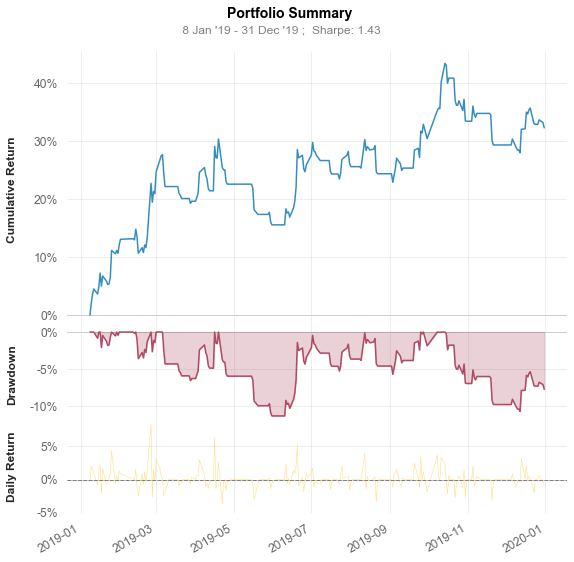

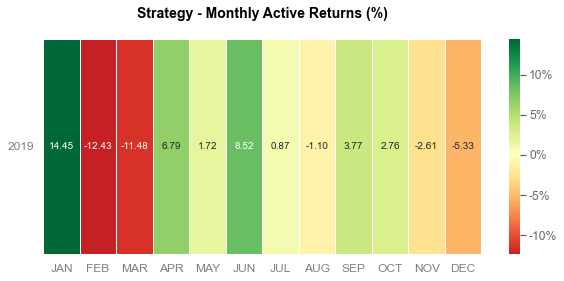

In [13]:
strategy = Strategy06
start_date = '20190101'
end_date   = '20200101'
stock_code = '000001'
index_code = '000905'

backtest(strategy, stock_code, index_code,
         start_date,end_date, 
         start_cash=1000000, report_mode='basic', price_type=None)